In [1]:
import os
import numpy as np

from scipy import fft, signal

from astropy.io import fits
from astropy import units as u
from astropy.modeling import models

from urllib.request import urlretrieve

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

logT range: 3.47-3.55

logg rannge: .04 - 0.51

Z range: 0.01578616580548934 - 0.03

In [3]:
10**3.47,10**3.55

(2951.209226666387, 3548.133892335753)

In [4]:
np.log10([.015,.03]) - np.log10(.02)

array([-0.12493874,  0.17609126])

get the teff ~ 3000 / 3600 + logg 0 / 0.5, Fe/H = 0 isochrones

In [5]:
s="""
ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte03600-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte03600-0.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte03000-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte03000-0.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
"""[1:-1]
urls = s.split()

In [6]:
fns = []
for url in urls:
    fns.append(url.split('/')[-1])
    fn = fns[-1]
    if os.path.exists(fn):
        print(fn, 'exists not dling')
    else:
        print(urlretrieve(url, fn))    

lte03600-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits exists not dling
lte03600-0.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits exists not dling
lte03000-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits exists not dling
lte03000-0.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits exists not dling


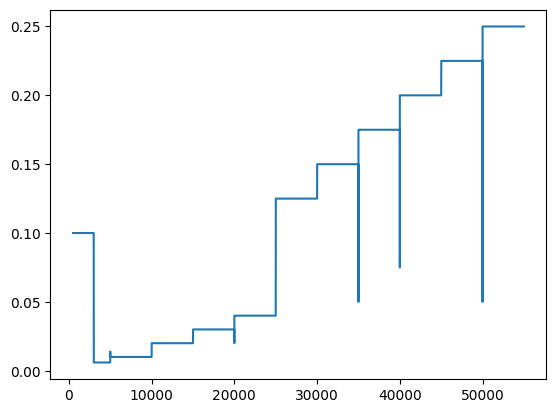

In [7]:
wls = fits.getdata('WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', 0)*u.angstrom
plt.plot(wls[:-1],np.diff(wls))

In [8]:
h0 = fits.getheader(fns[0], 0)
fluxes = u.Quantity([fits.getdata(fn, 0) for fn in fns], h0['BUNIT']).to(u.erg/u.s * u.cm**-2 / u.angstrom)
fluxes.unit, fluxes.shape

(Unit("erg / (Angstrom s cm2)"), (4, 1569128))

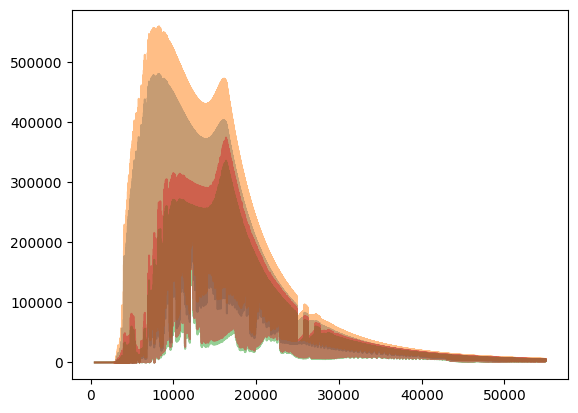

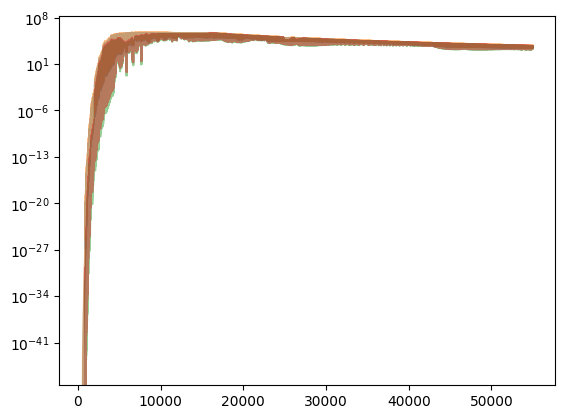

In [9]:
for flux in fluxes:
    plt.plot(wls, flux, alpha=.5)

plt.figure()
for flux in fluxes:
    plt.semilogy(wls, flux, alpha=.5)


(0.0, 600000.0)

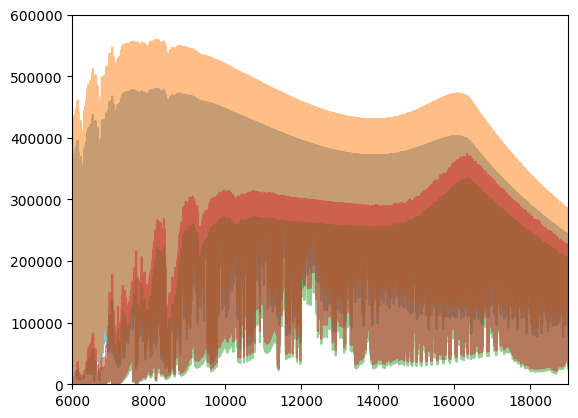

In [10]:
for flux in fluxes:
    plt.plot(wls, flux, alpha=.5)

plt.xlim(6000,19000)
plt.ylim(0, .6e6)

(100, 1000000.0)

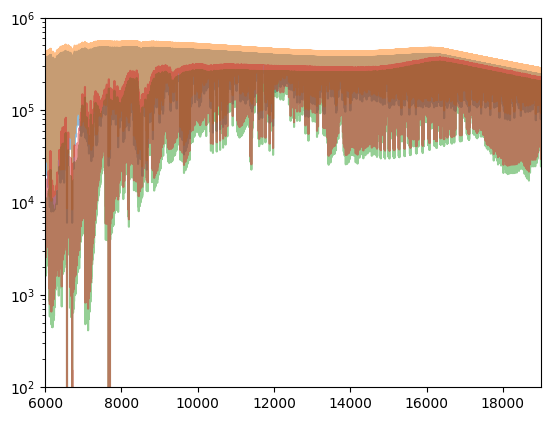

In [11]:
for flux in fluxes:
    plt.semilogy(wls, flux, alpha=.5)

plt.xlim(6000,19000)
plt.ylim(100, 1e6)

First try some standard normalization tricks

In [12]:
from specutils import Spectrum1D, manipulation, analysis, fitting, SpectralRegion

In [13]:
ss = [Spectrum1D(flux=flux, spectral_axis=wls) for flux in fluxes]

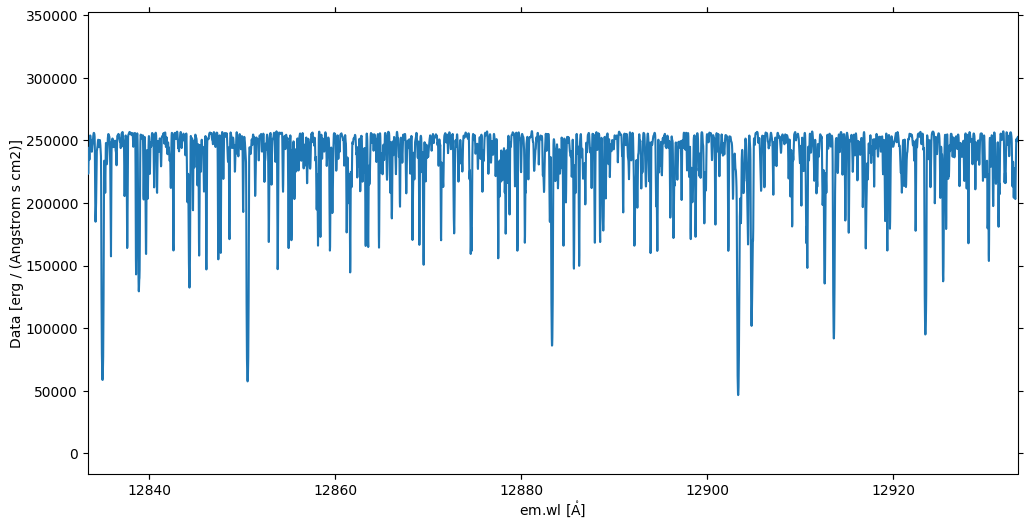

In [14]:
plt.figure(figsize=(12, 6))

ss[2].plot()
plt.xlim(1000000, 1000000+5000)
wpx = plt.gca().wcs.pixel_to_world(plt.xlim())

In [15]:
fcr = manipulation.resample.FluxConservingResampler()

coarse_wl = np.linspace(8000, 13000, 2048)*u.angstrom
coarse_ss = [fcr(s, coarse_wl) for s in ss]

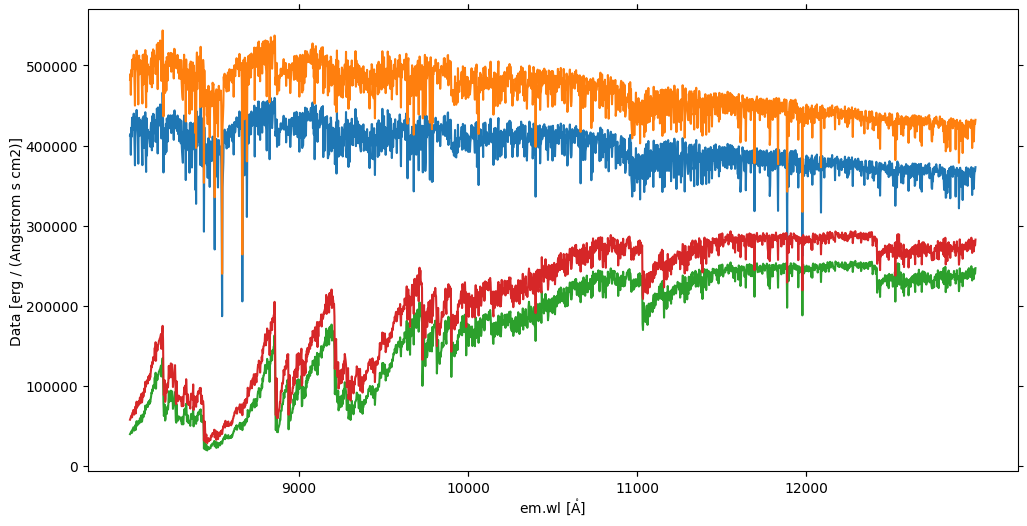

In [16]:
fig = plt.figure(figsize=(12, 6))

ax = None

for s in coarse_ss:
    if ax is None:
        ax = s.plot()
    else:
        s.plot(axes=ax)

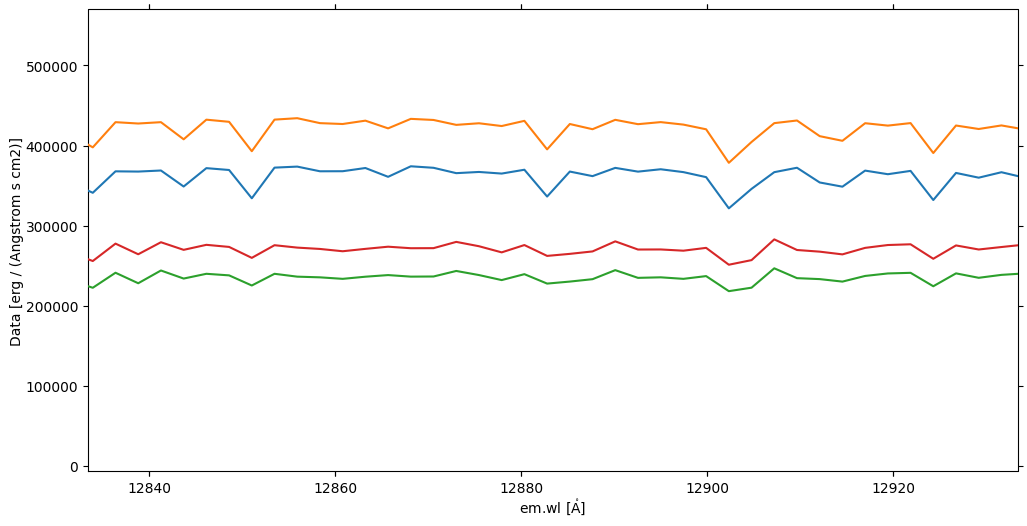

In [17]:
ax.set_xlim(*ax.wcs.world_to_pixel(wpx))
fig

In [18]:
ers = [SpectralRegion(8500*u.nm, 10000*u.nm)]  #the funky TiO band and related features
contspecs = [Spectrum1D(spectral_axis=s.spectral_axis, flux=fitting.fit_generic_continuum(s, exclude_regions=ers)(s.spectral_axis)) for s in coarse_ss]
contnorm = [s/cs for s, cs in zip(coarse_ss, contspecs)]
contsub = [s-cs for s, cs in zip(coarse_ss, contspecs)]

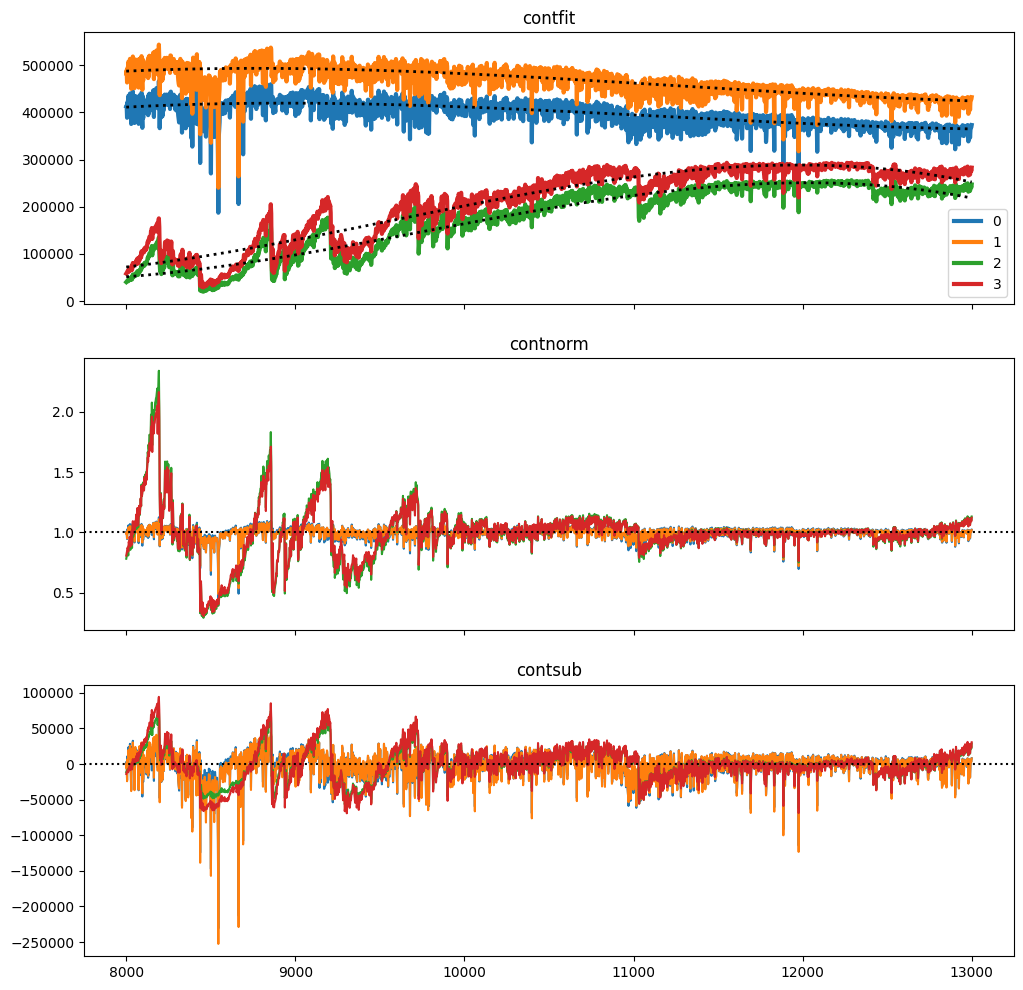

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, (s, cs) in enumerate(zip(coarse_ss, contspecs)):
    line = ax1.plot(s.spectral_axis, s.flux, zorder=1, lw=3, label=i)[0]
    ax1.plot(cs.spectral_axis, cs.flux, zorder=2, ls=':', lw=2, 
             color='k', #color=line.get_color()
            )
ax1.set_title('contfit')
ax1.legend(loc=0)

for s in contnorm:
    ax2.plot(s.spectral_axis, s.flux)
ax2.axhline(1, c='k', ls=':')
ax2.set_title('contnorm')

for s in contsub:
    ax3.plot(s.spectral_axis, s.flux)
ax3.axhline(0, c='k', ls=':')
ax3.set_title('contsub');

## Spectral analysis

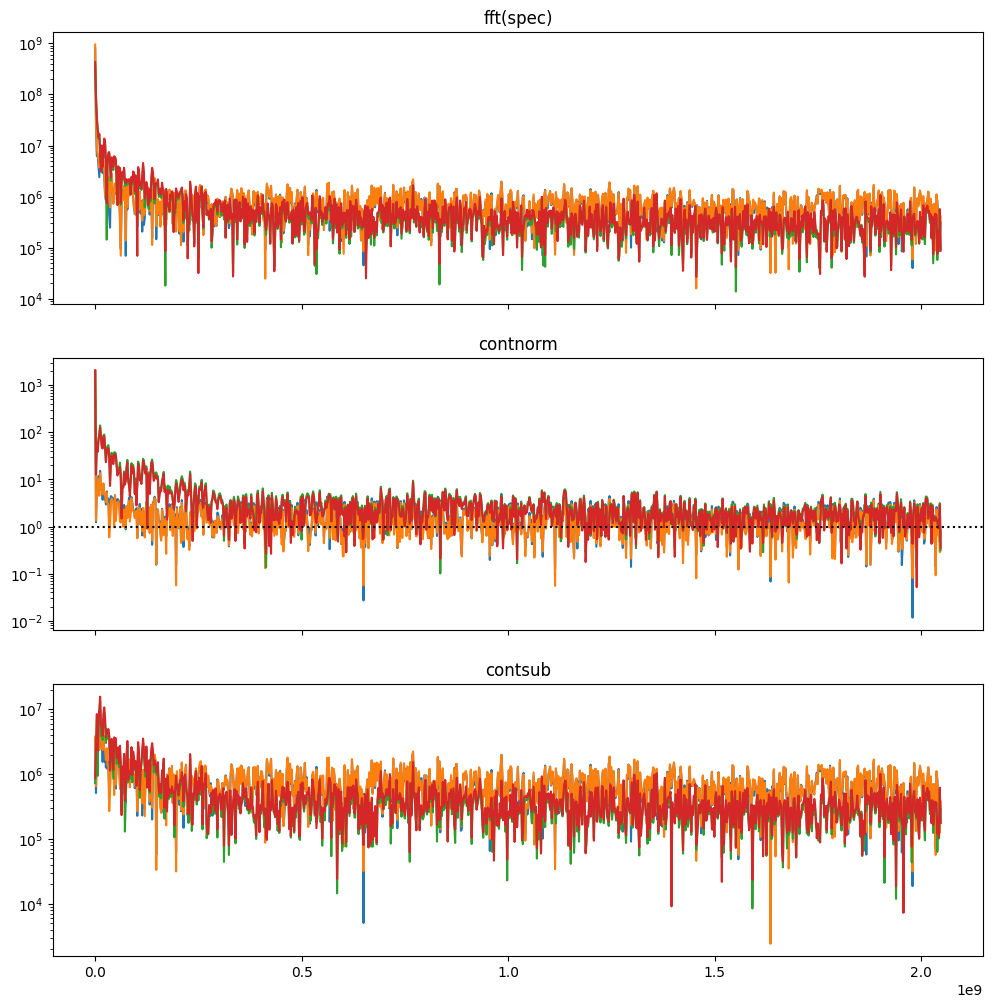

In [20]:
rfftx = fft.rfftfreq(len(coarse_wl), d=np.mean(np.diff(coarse_wl.to(u.m))))

fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
ax1, ax2, ax3 = axs

for s, cs in zip(coarse_ss, contspecs):
    ax1.plot(rfftx, np.abs(fft.rfft(s.flux)))
ax1.set_title('fft(spec)')

for s in contnorm:
    ax2.plot(rfftx, np.abs(fft.rfft(s.flux)),)
ax2.axhline(1, c='k', ls=':')
ax2.set_title('contnorm')

for s in contsub:
    ax3.plot(rfftx, np.abs(fft.rfft(s.flux)),)
ax3.axhline(0, c='k', ls=':')
ax3.set_title('contsub')

for ax in axs:
    ax.semilogy()

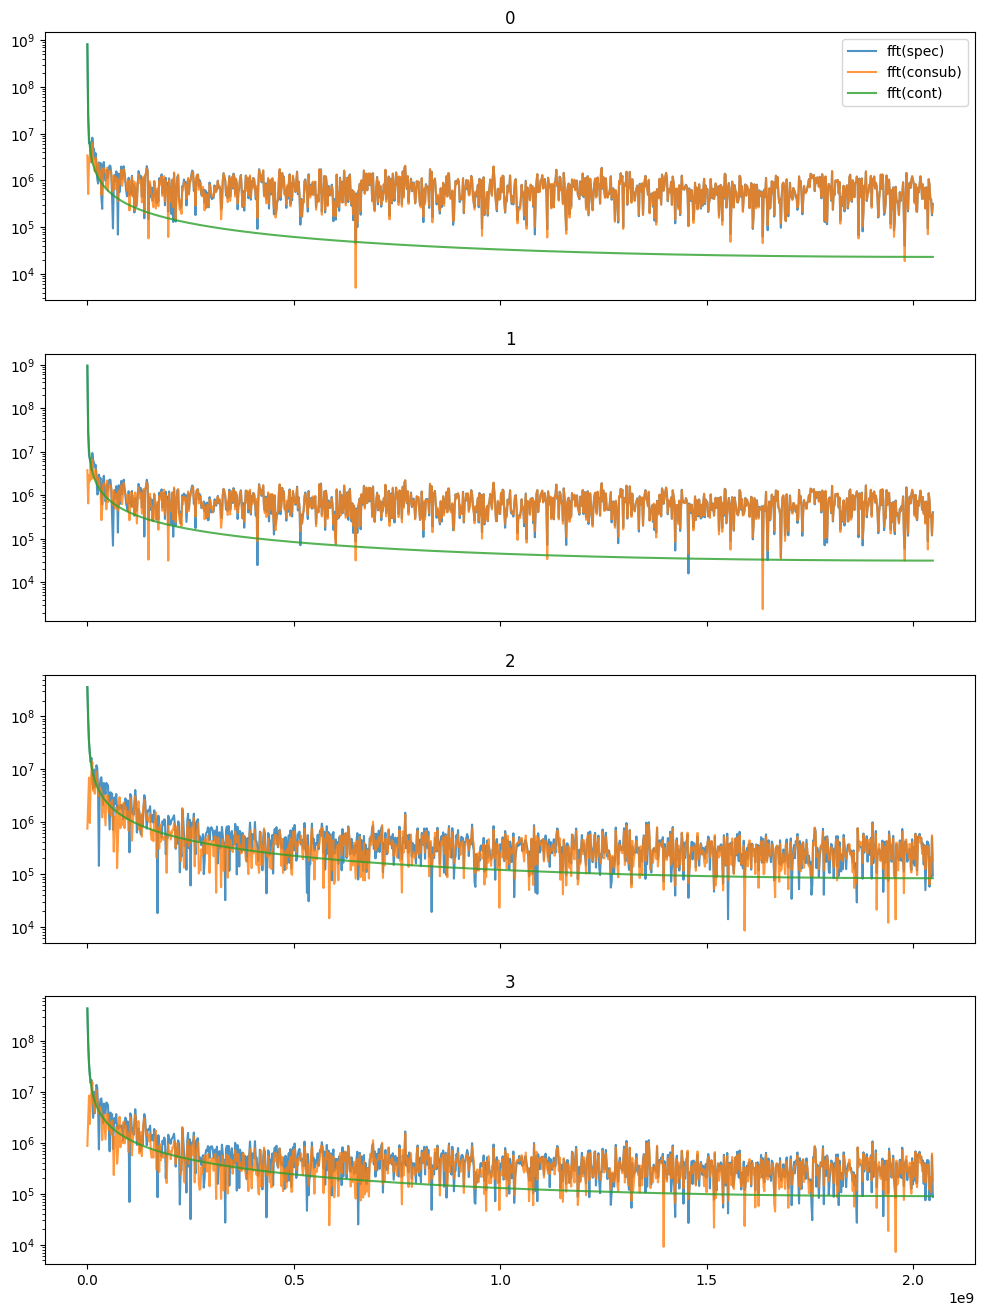

In [21]:
rfftx = fft.rfftfreq(len(coarse_wl), d=np.mean(np.diff(coarse_wl.to(u.m))))

fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

for i, (s, cn, cs, csp, ax) in enumerate(zip(coarse_ss, contnorm, contsub, contspecs, axs.ravel())):
    ax.plot(rfftx, np.abs(fft.rfft(s.flux)), label='fft(spec)', alpha=.8)
    #ax.plot(rfftx, np.abs(fft.rfft(cn.flux)), label='fft(contnorm)', alpha=.8)
    ax.plot(rfftx, np.abs(fft.rfft(cs.flux)), label='fft(consub)', alpha=.8)
    ax.plot(rfftx, np.abs(fft.rfft(csp.flux)), label='fft(cont)', alpha=.8)
    ax.semilogy()
    ax.set_title(i)

axs.ravel()[0].legend(loc=0)

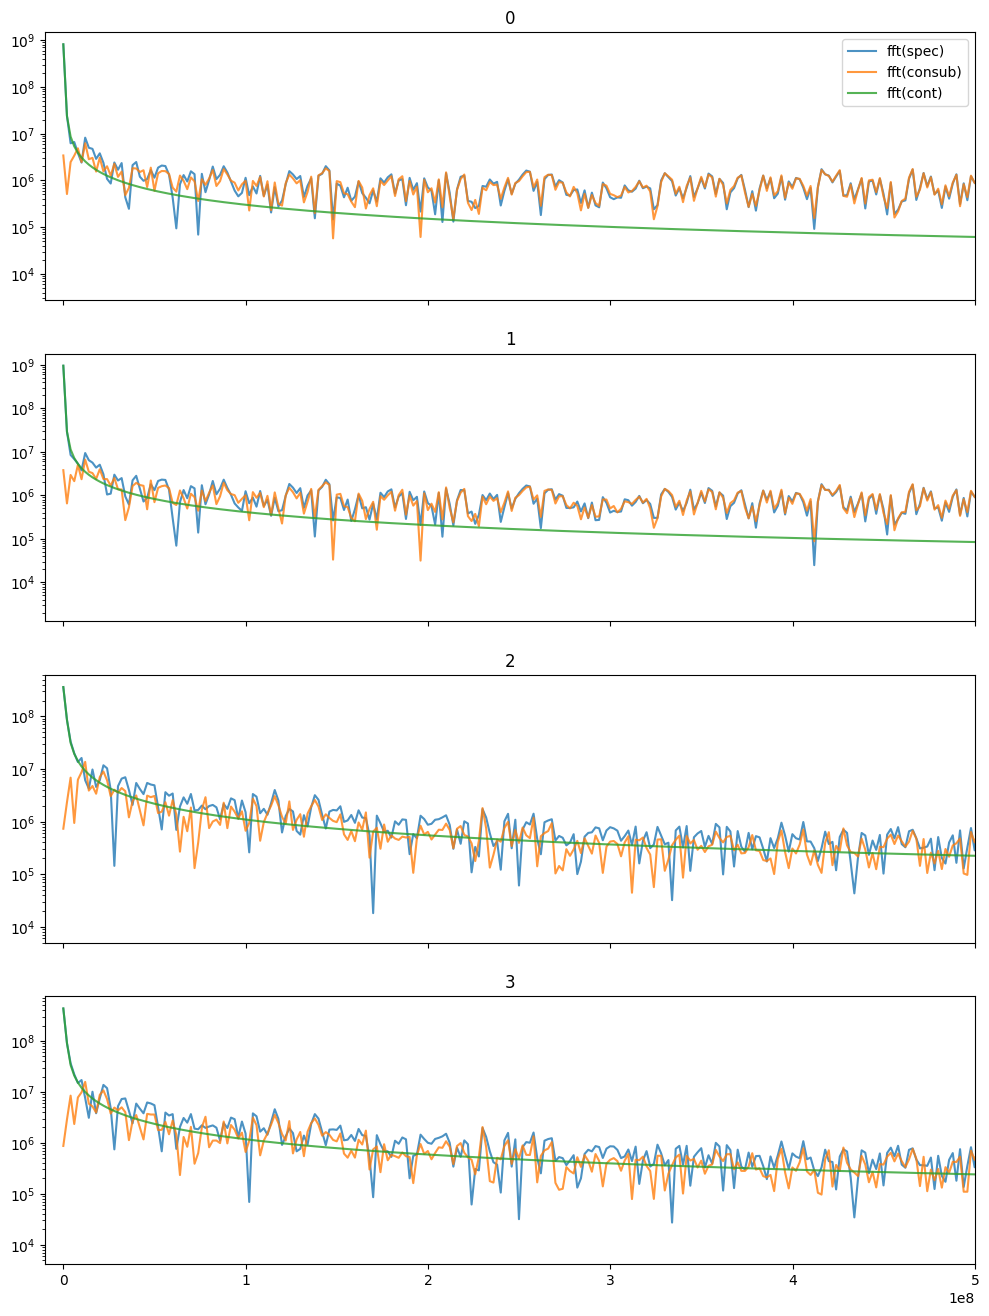

In [22]:
for ax in axs.ravel():
    ax.set_xlim(-1e7, 5e8)
fig

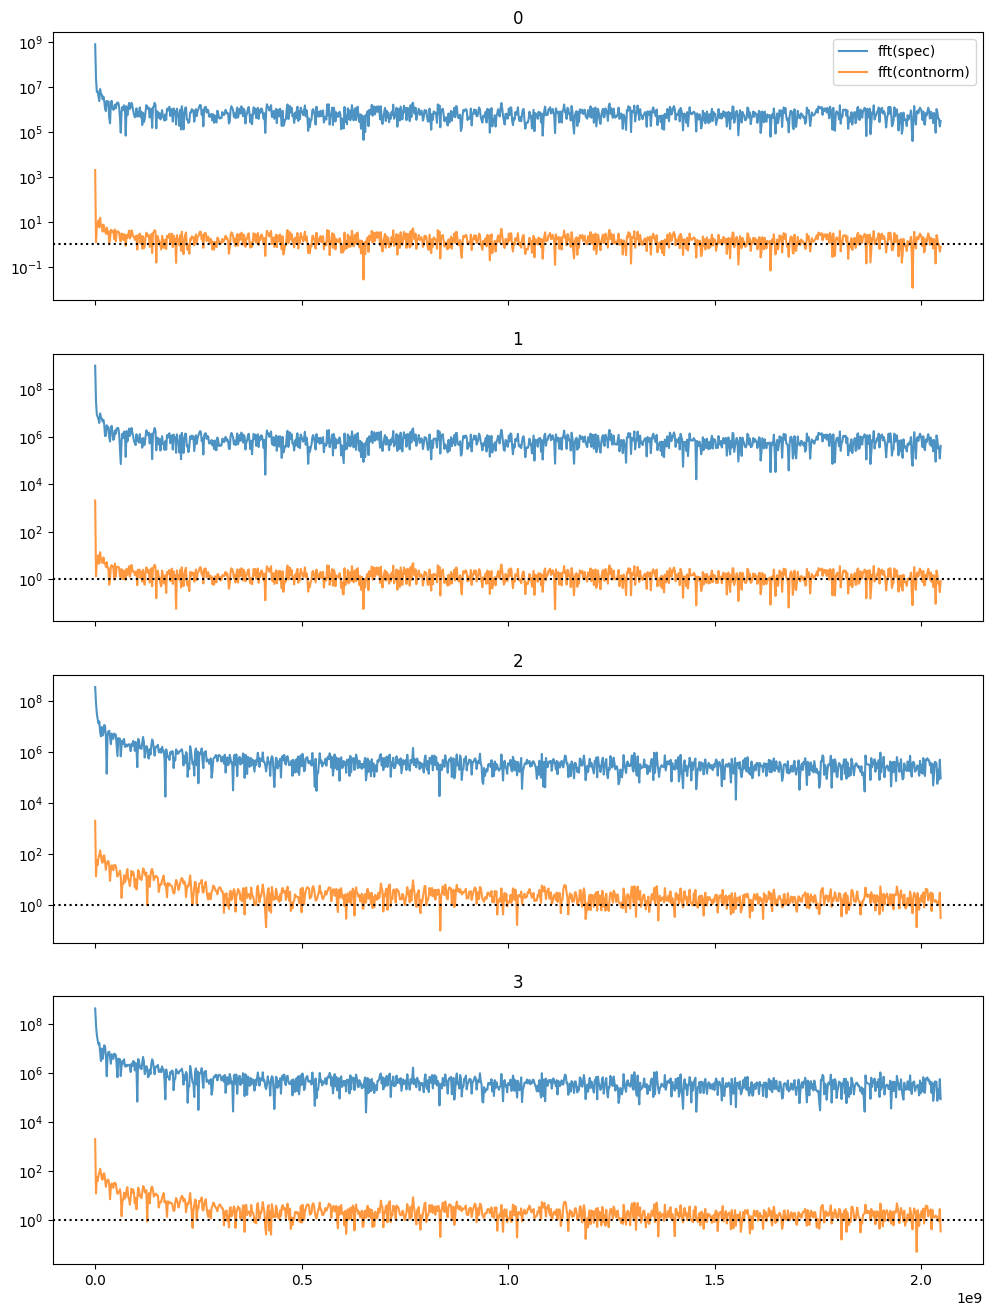

In [23]:
rfftx = fft.rfftfreq(len(coarse_wl), d=np.mean(np.diff(coarse_wl.to(u.m))))

fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

for i, (s, cn, cs, csp, ax) in enumerate(zip(coarse_ss, contnorm, contsub, contspecs, axs.ravel())):
    ax.plot(rfftx, np.abs(fft.rfft(s.flux)), label='fft(spec)', alpha=.8)
    ax.plot(rfftx, np.abs(fft.rfft(cn.flux)), label='fft(contnorm)', alpha=.8)
    #ax.plot(rfftx, np.abs(fft.rfft(cs.flux)), label='fft(consub)', alpha=.8)
    #ax.plot(rfftx, np.abs(fft.rfft(csp.flux)), label='fft(cont)', alpha=.8)
    ax.semilogy()
    ax.set_title(i)
    ax.axhline(1, c='k', ls=':')

axs.ravel()[0].legend(loc=0)

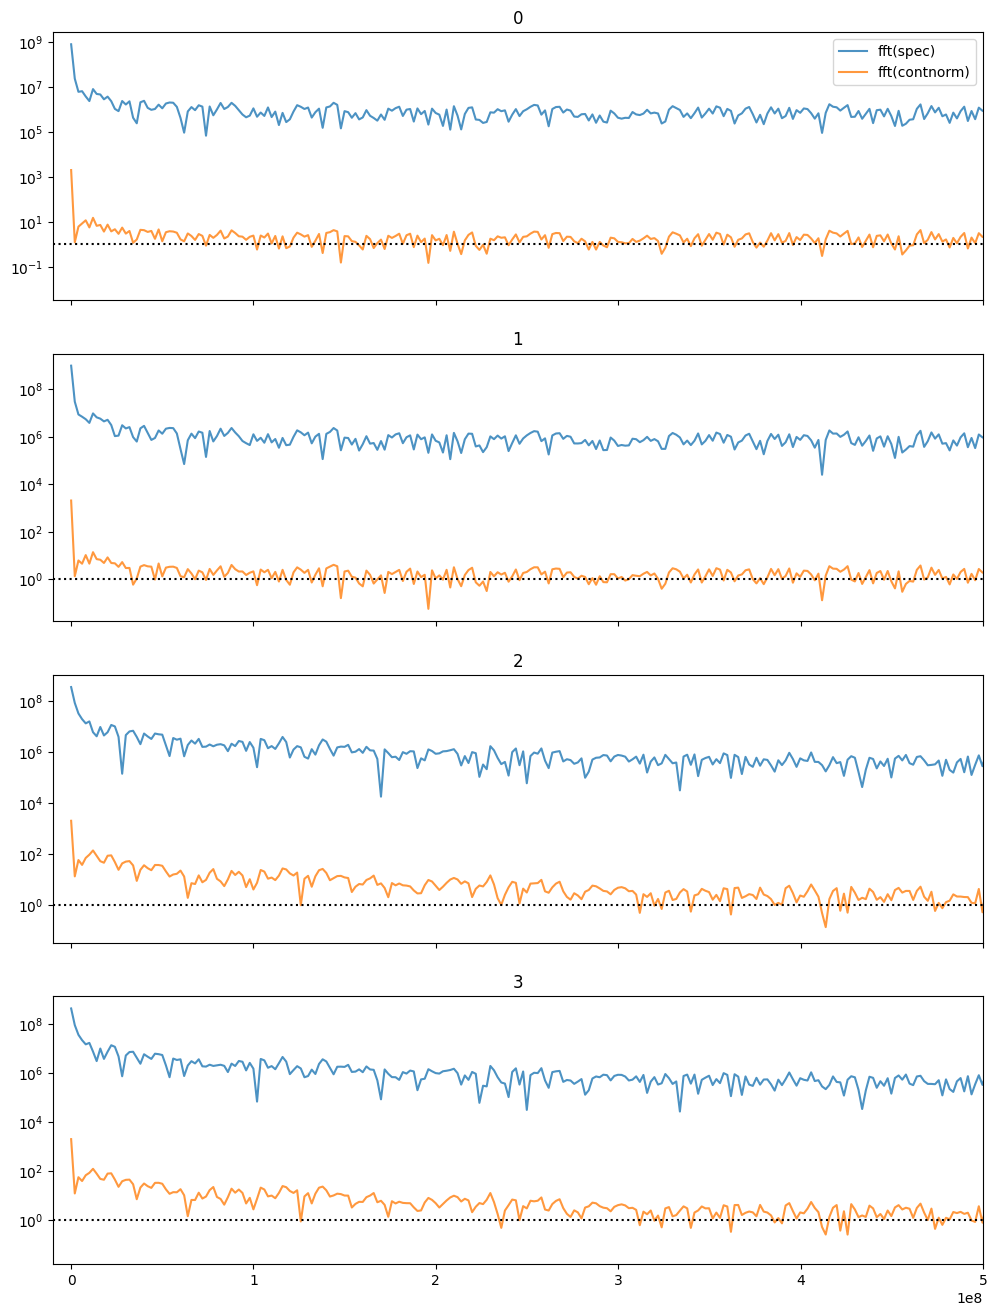

In [24]:
for ax in axs.ravel():
    ax.set_xlim(-1e7, 5e8)
fig

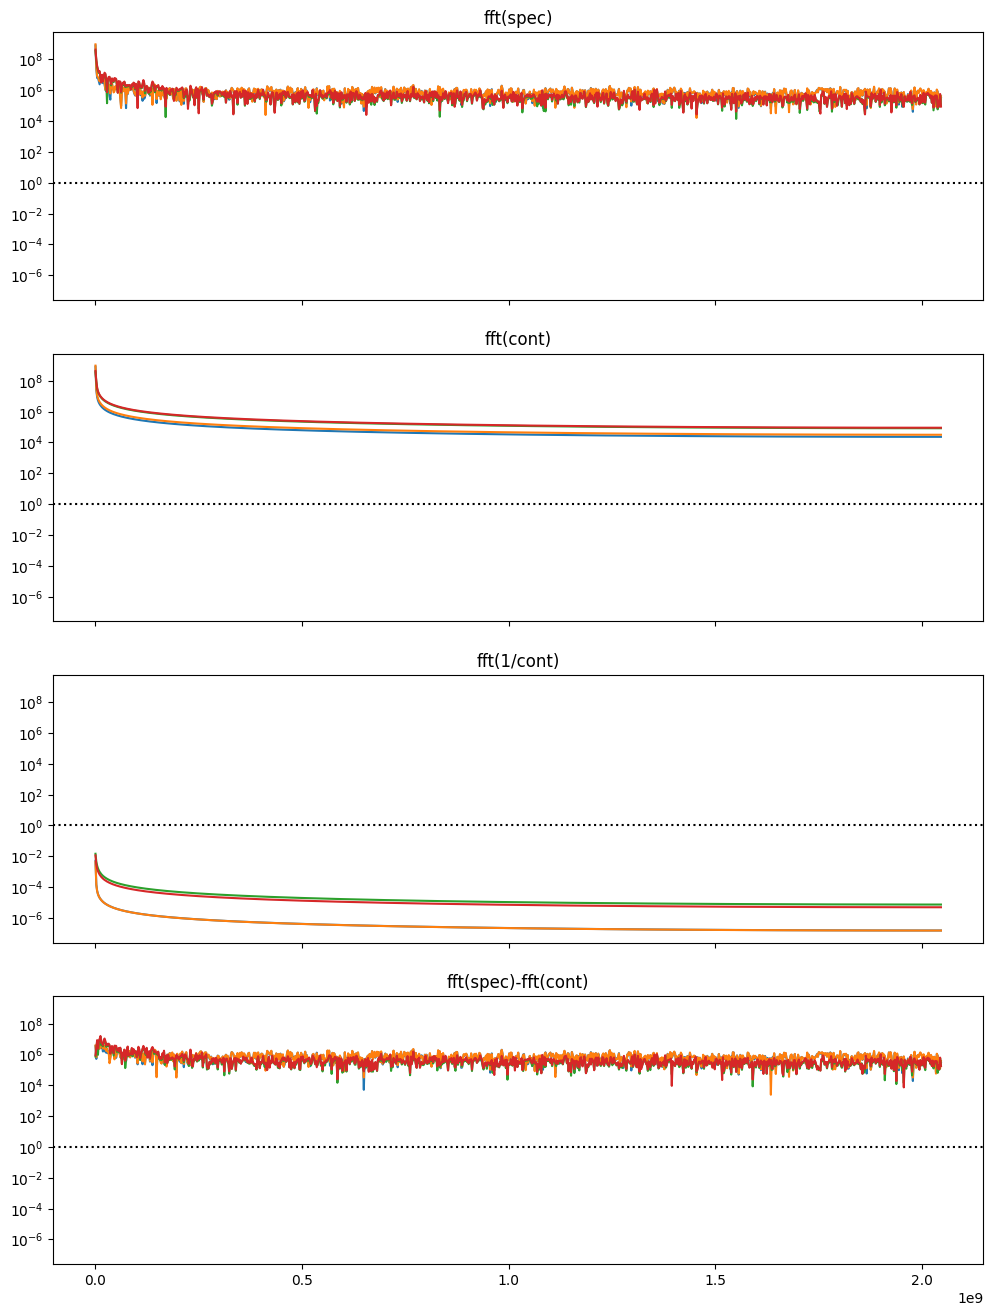

In [25]:
rfftx = fft.rfftfreq(len(coarse_wl), d=np.mean(np.diff(coarse_wl.to(u.m))))

fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True, sharey=True)
ax1, ax2, ax3, ax4 = axs

for s in coarse_ss:
    ax1.plot(rfftx, np.abs(fft.rfft(s.flux)))
ax1.set_title('fft(spec)')

for s in contspecs:
    ax2.plot(rfftx, np.abs(fft.rfft(s.flux)),)
ax2.set_title('fft(cont)')

for s in contspecs:
    ax3.plot(rfftx, np.abs(fft.rfft(1/s.flux)),)
ax3.set_title('fft(1/cont)')

for s, cs in zip(coarse_ss, contspecs):
    ax4.plot(rfftx, np.abs(fft.rfft(s.flux) - fft.rfft(cs.flux)),)
ax4.set_title('fft(spec)-fft(cont)')

for ax in axs:
    ax.semilogy()
    ax.axhline(1, c='k', ls=':')

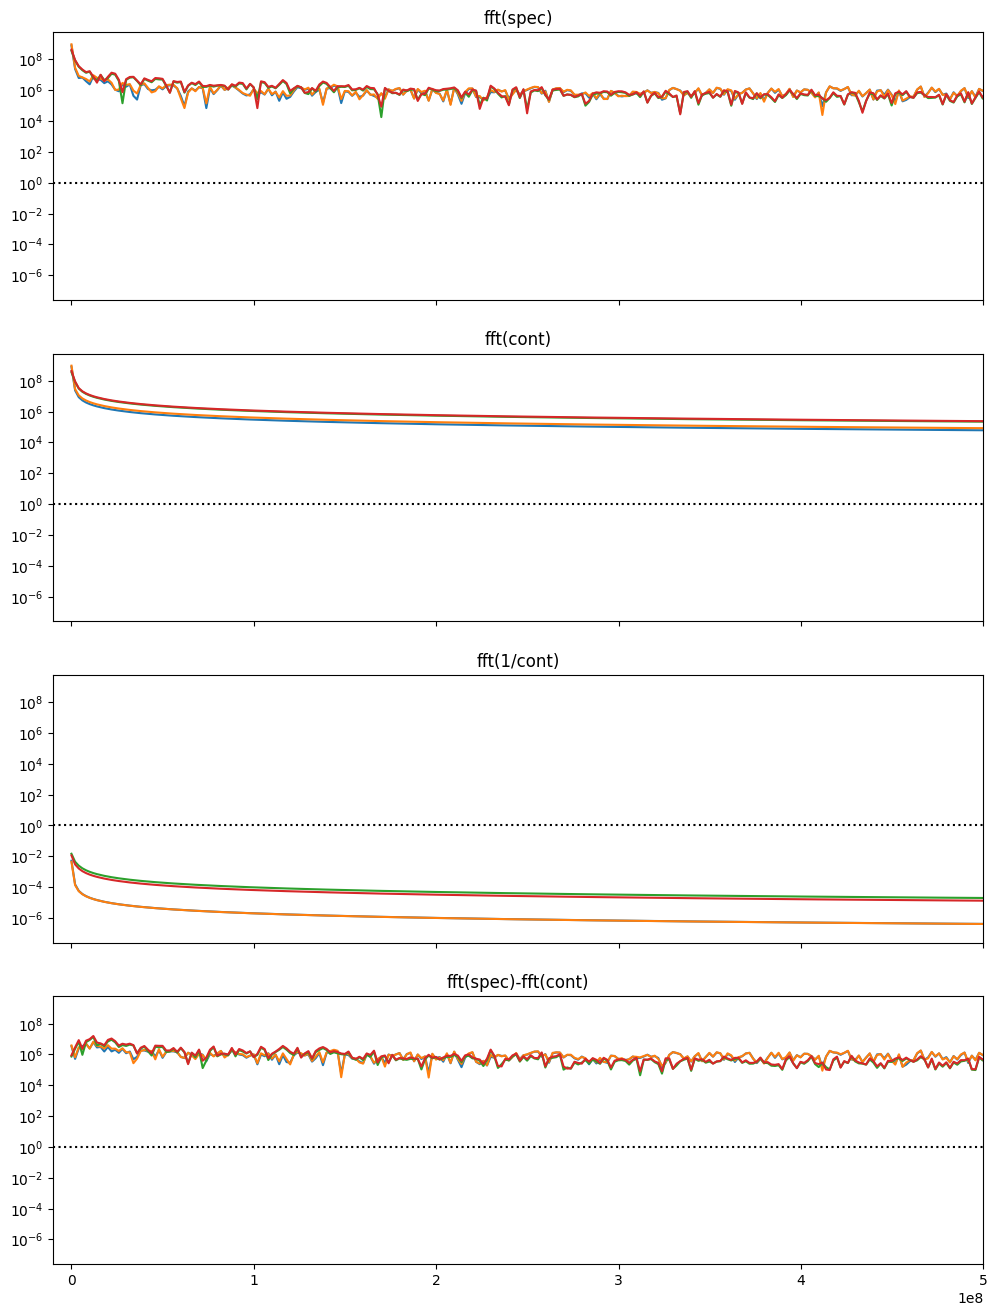

In [26]:
for ax in axs.ravel():
    ax.set_xlim(-1e7, 5e8)
fig

##  try a spectral cutoff approach:

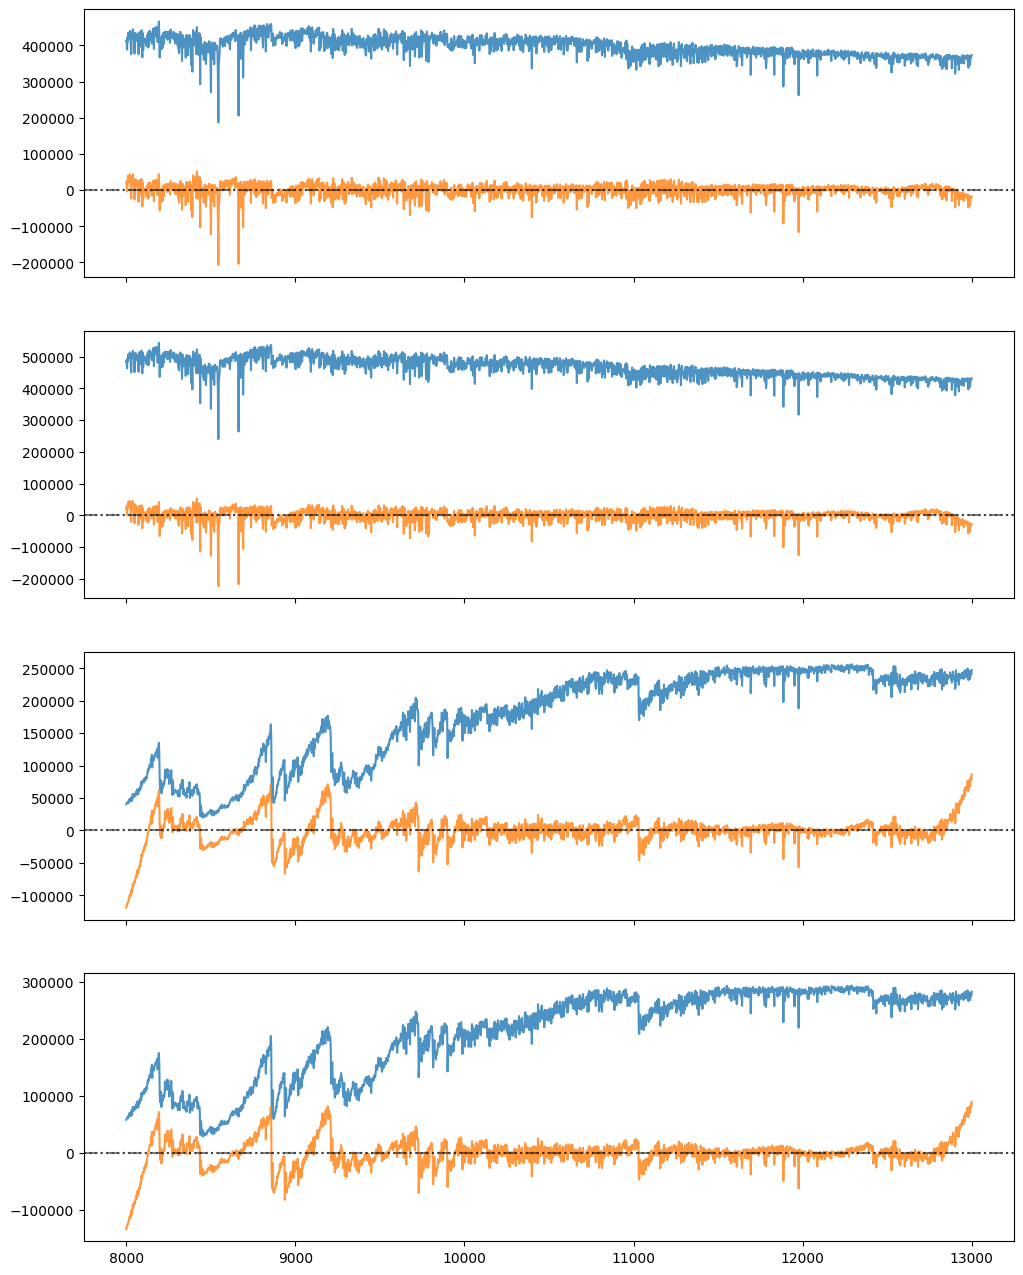

In [27]:
filtered_specs = []
for s in coarse_ss:
    fu = s.flux.unit
    sF = fft.rfft(s.flux)
    sF[:10] = np.mean(sF[10:])
    filtered = fft.irfft(sF)
    
    filtered_specs.append(Spectrum1D(spectral_axis=coarse_wl, flux=filtered << fu))
    
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

for i, (s, fs, ax) in enumerate(zip(coarse_ss, filtered_specs, axs.ravel())):
    ax.plot(s.spectral_axis, s.flux, alpha=.8, label='spec')
    ax.plot(fs.spectral_axis, fs.flux, alpha=.8, label='filtered spec')
    ax.axhline(1, c='k', ls=':', alpha=.5)
    ax.axhline(0, c='k', ls='-.', alpha=.5)

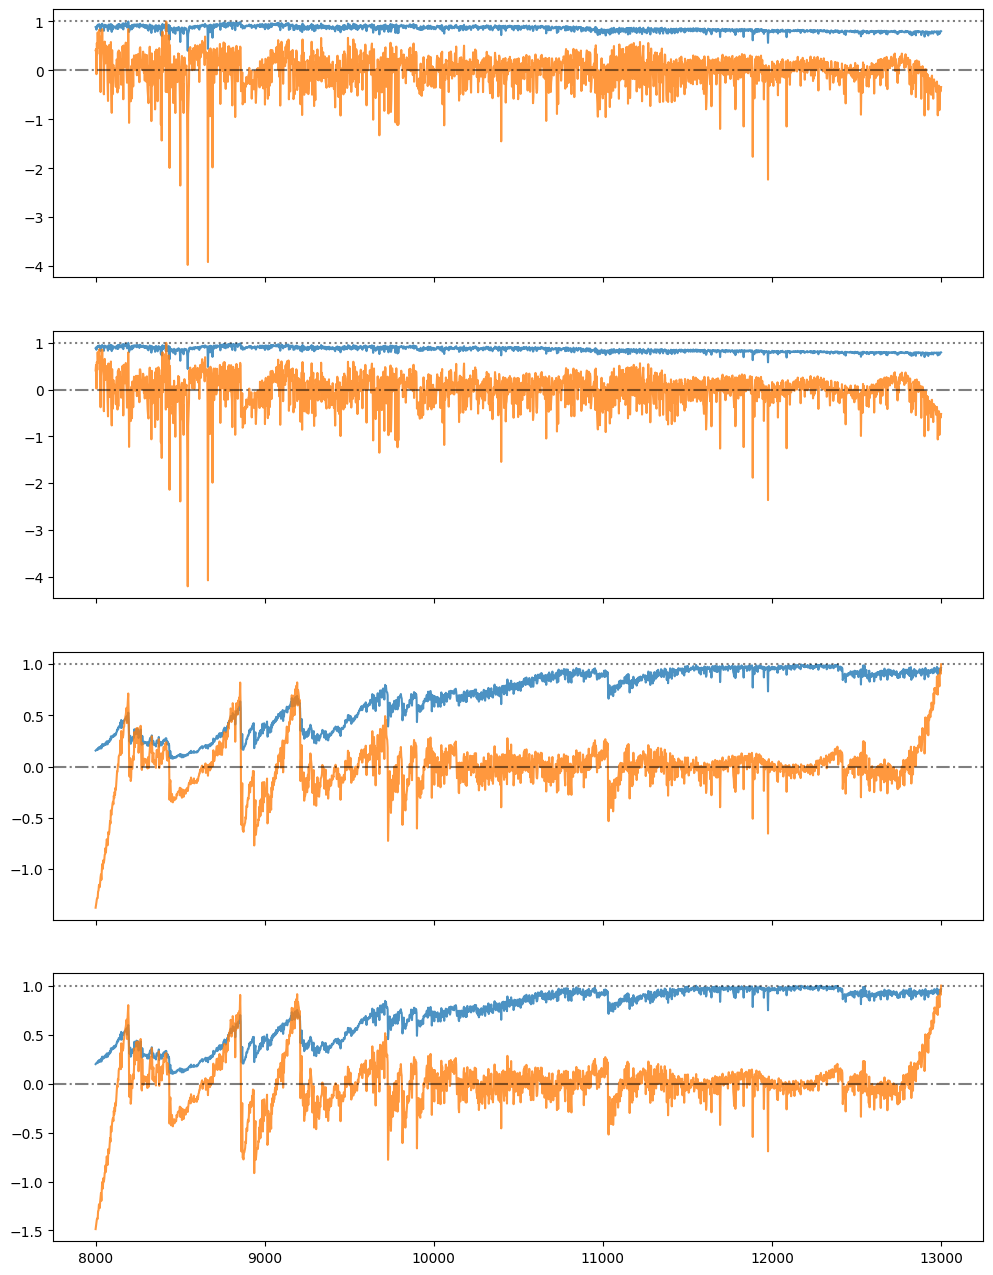

In [28]:
filtered_specs = []
for s in coarse_ss:
    fu = s.flux.unit
    sF = fft.rfft(s.flux)
    #sF[:10] = 0
    sF[:10] = np.mean(sF[10:])
    #sF[0] = len(sF)*2
    filtered = fft.irfft(sF)
    
    filtered_specs.append(Spectrum1D(spectral_axis=coarse_wl, flux=filtered << fu))
    
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

for i, (s, fs, ax) in enumerate(zip(coarse_ss, filtered_specs, axs.ravel())):
    ax.plot(s.spectral_axis, s.flux/np.max(s.flux), alpha=.8, label='spec')
    ax.plot(fs.spectral_axis, fs.flux/np.max(fs.flux), alpha=.8, label='filtered spec')
    ax.axhline(1, c='k', ls=':', alpha=.5)
    ax.axhline(0, c='k', ls='-.', alpha=.5)

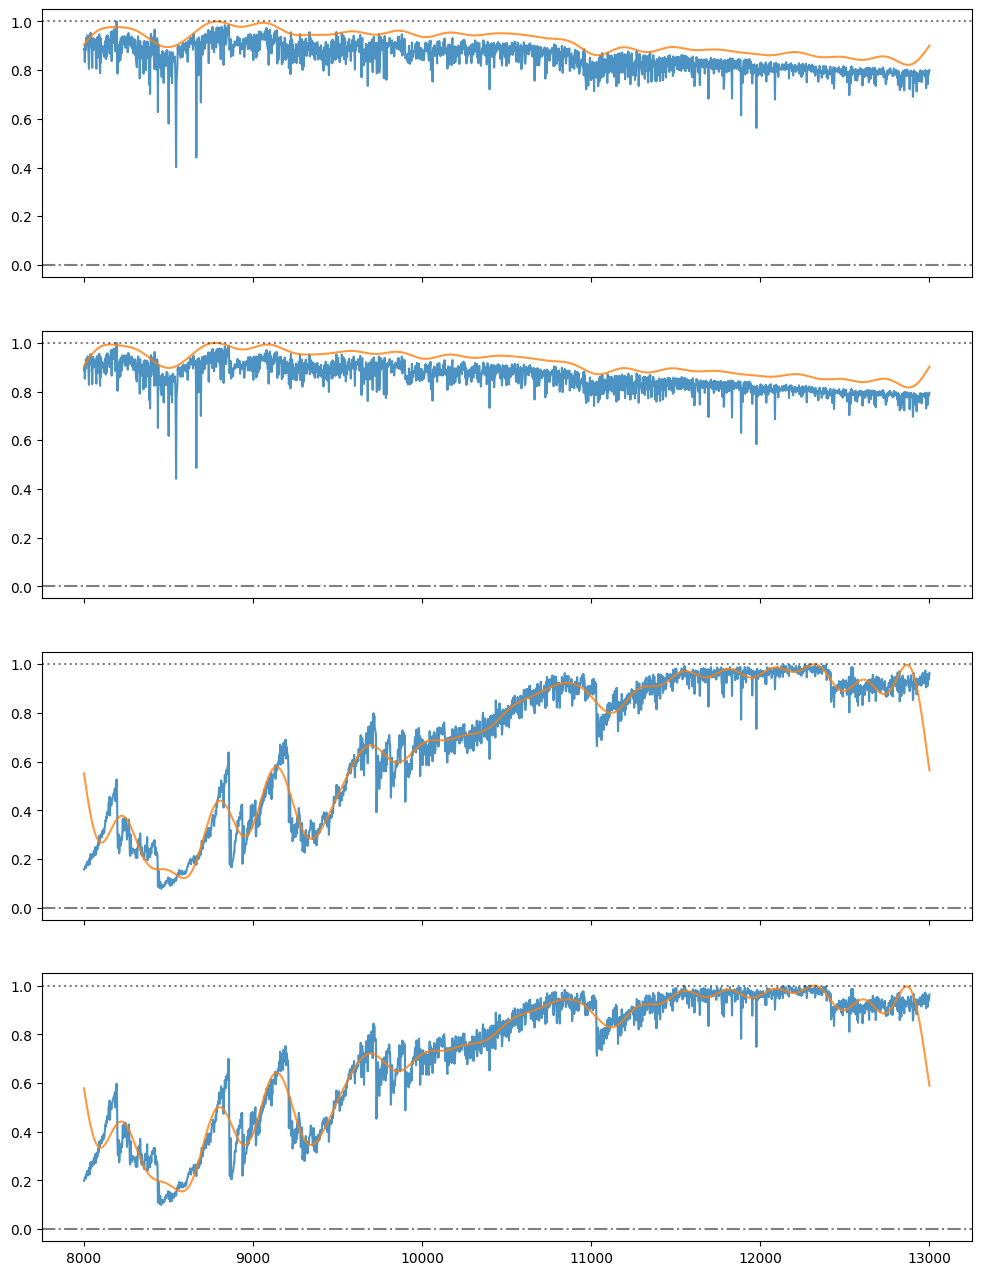

In [29]:
filtered_specs = []
for s in coarse_ss:
    fu = s.flux.unit
    sF = fft.rfft(s.flux)
    sF[20:] = 0
    #sF[0] = len(sF)*2
    filtered = fft.irfft(sF)
    
    filtered_specs.append(Spectrum1D(spectral_axis=coarse_wl, flux=filtered << fu))
    
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

for i, (s, fs, ax) in enumerate(zip(coarse_ss, filtered_specs, axs.ravel())):
    ax.plot(s.spectral_axis, s.flux/np.max(s.flux), alpha=.8, label='spec')
    ax.plot(fs.spectral_axis, fs.flux/np.max(fs.flux), alpha=.8, label='filtered spec')
    ax.axhline(1, c='k', ls=':', alpha=.5)
    ax.axhline(0, c='k', ls='-.', alpha=.5)

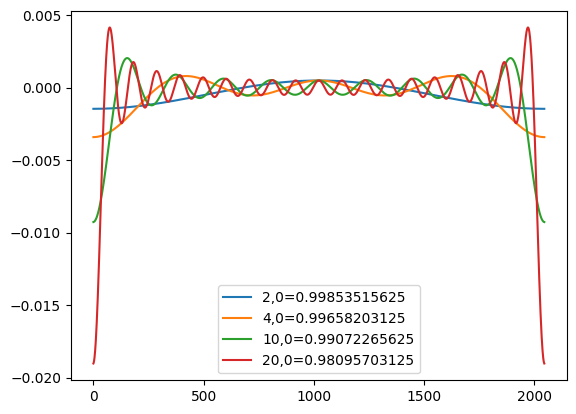

In [30]:
filter = fft.rfft(np.ones(coarse_wl.size))

for i in [2, 4, 10, 20]:
    filter[:] = 1
    filter[:i] = 0

    iff = fft.irfft(filter)
    plt.plot(iff[1:], label=f"{i},0={iff[0]}")

plt.legend(loc=0)

In [31]:
2048/100

20.48

[<Quantity 2.52244147>,
 <Quantity 1.84924248>,
 <Quantity 0.88057429>,
 <Quantity 0.45374773>]

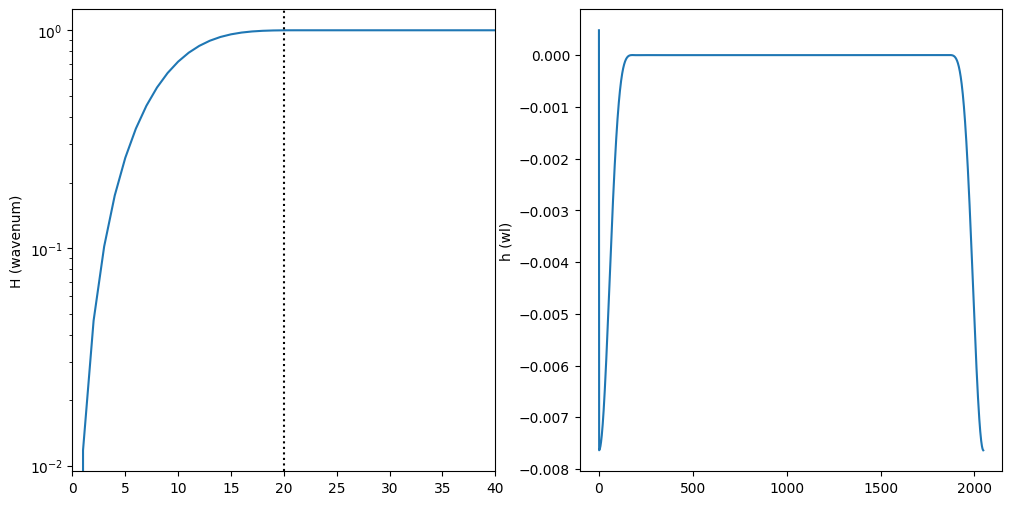

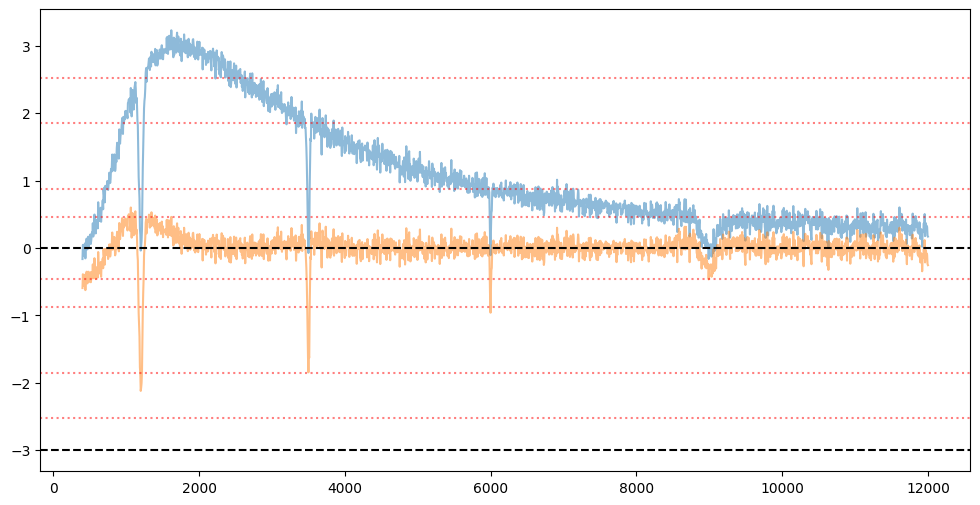

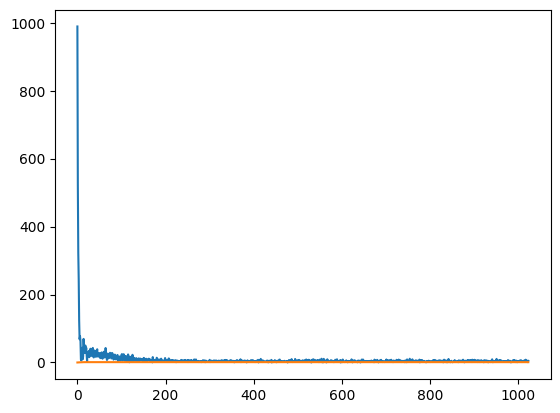

In [32]:
taper = 20
filter = np.ones(1025)
filter[:taper+1] = 1-signal.windows.kaiser(taper*2 + 1, 10)[taper:]
#filter[:taper+1] = 1-signal.windows.chebwin(taper*2 + 1, 100)[taper:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(filter)
ax1.set_xlim(0, taper*2)
ax1.axvline(taper, c='k', ls=':')
ax1.set_ylabel('H (wavenum)')
ax1.semilogy()
ax2.plot(fft.irfft(filter-np.mean(filter)))
ax2.set_ylabel('h (wl)')



plt.figure(figsize=(12, 6))
xm = np.linspace(400,12000,2048)*u.nm
bbm = models.BlackBody(temperature=3000*u.K)
m = bbm(xm)
mx = m.max()/3
m = (m/mx).value

mg = m.copy()
linedges = []
for lincen, lins in [(1200, 25), (3500, 15), (6000, 10), (9000, 100)]:
    mg *= 1-models.Gaussian1D(mean=lincen, stddev=lins)(xm.value)
    linedges.append(bbm(lincen*xm.unit)/mx)

s = np.random.randn(2048)*.1 + mg
plt.plot(xm, s, alpha=.5)

plt.plot(xm, fft.irfft(filter*fft.rfft(s)), alpha=.5)
plt.axhline(0, c='k', ls='--')
plt.axhline(-3, c='k', ls='--')
for e in linedges:
    plt.axhline(e, alpha=.5, c='r', ls=':')
    plt.axhline(-e, alpha=.5, c='r', ls=':')

plt.figure()
plt.plot(np.abs(fft.rfft(s))[1:])
plt.plot(filter[1:])

linedges

Try reconstructing the effective smoothing windows of the continuum filters

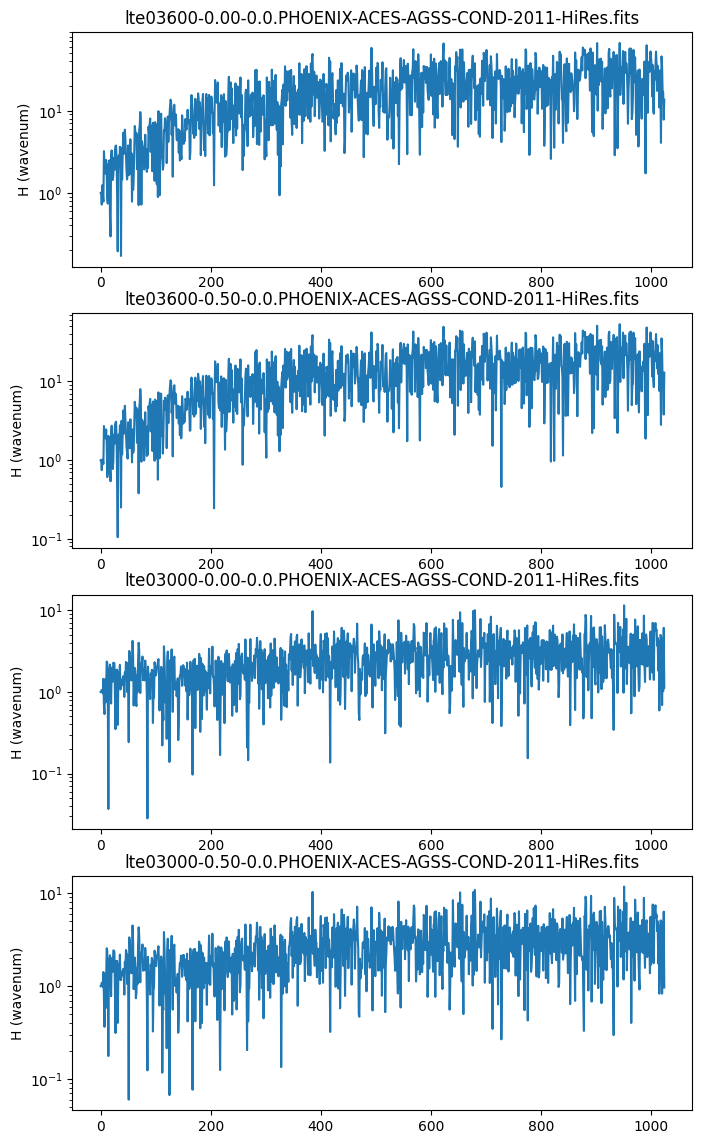

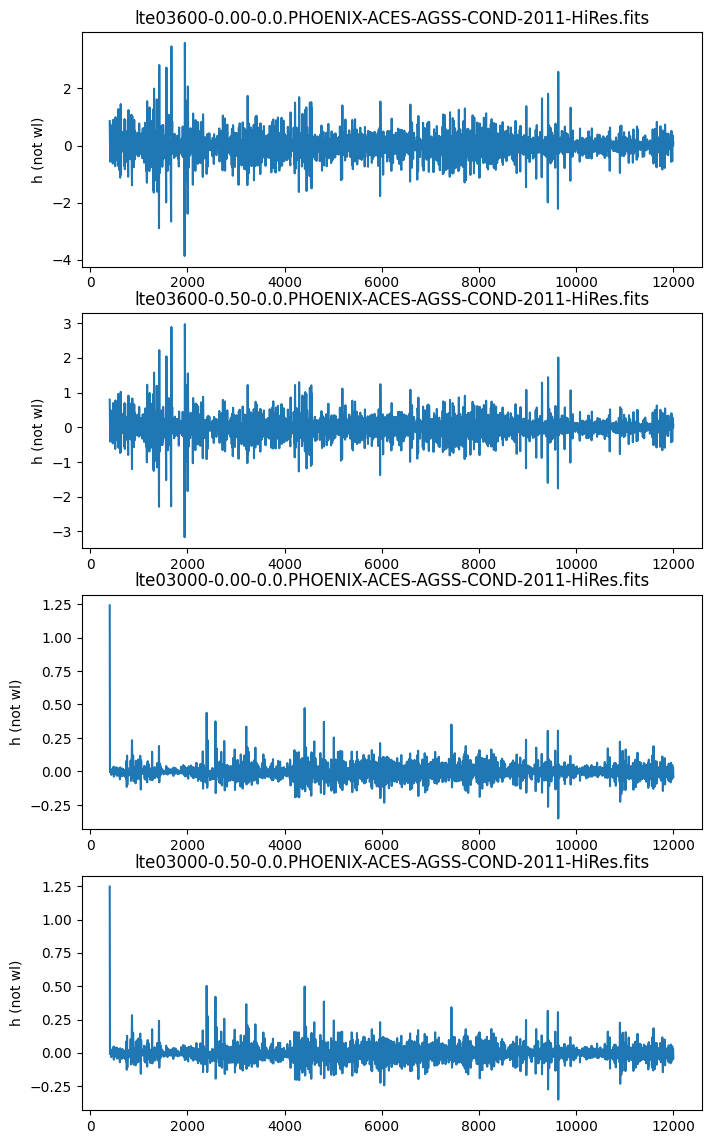

In [33]:
Hs = [fft.rfft(s.flux)/fft.rfft(cs.flux) for cs, s in zip(contspecs, coarse_ss)]
hs = [fft.irfft(H) for H in Hs]

fig, axs = plt.subplots(4, 1, figsize=(8, 14))
for H, ax, fn in zip(Hs, axs.ravel(), fns):
    aH = np.abs(H)
    ax.plot(aH)
    ax.semilogy()
    ax.set_title(fn)
    ax.set_ylabel('H (wavenum)')

fig2, axs2 = plt.subplots(4, 1, figsize=(8, 14))
for h, ax, fn in zip(hs, axs2.ravel(), fns):
    ax.plot(xm, h)
    ax.set_title(fn)
    ax.set_ylabel('h (not wl)')